In [760]:
import sys
import datetime
import pandas as pd
import numpy as np
import datetime as dt
import time
import math
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import plotly.graph_objects as go
from scipy.signal import argrelextrema
from scipy.stats import linregress
#import autosklearn

sys.path.append('C:/workarea/mylib/')
sys.path.append('C:/workarea/mylib/quant')
sys.path.append('C:/workarea/mylib/history')
import quant as q
import quant.helpers as hlp
from history import bt, history_tools as ht

import warnings
warnings.filterwarnings("ignore")
locx = 'S:/Matrix/IA/IADE/0_Personal/1_Antonio/risk_return_contribution/pricing/files/'

def get_freq(data, datecol='t', freq='5min'):
    data = data.set_index(pd.DatetimeIndex(data[datecol]))
    data.index.name = None
    df = pd.DataFrame()
    df['o'] = data.o.resample(freq).first()
    df['h'] = data.h.resample(freq).max()
    df['l'] = data.l.resample(freq).min()
    df['c'] = data.c.resample(freq).last()
    df['v'] = data.v.resample(freq).sum()
    return df.reset_index().rename(columns={'index':datecol})

def rebase(x, basedate_, baseval=100):
    x = x[x.index >= basedate_]
    return x.iloc[:, :] / x.iloc[0, :] * baseval

def rets_to_ts(df1, basedate, baseval=100, datecol='', dropfirstrow=False):
    '''calculates time series based on returns (format: output file from calc_rets_pf)
    inputs: df1 - dataframe in format calc_rets_pf()
            datecolum: if parameter not empty list, then will use that as index for the date
    output: dataframe with time series added to h_ column; base date and value are added
    '''
    basedate = pd.to_datetime(basedate, format='%Y-%m-%d', dayfirst=True)
    if dropfirstrow:
        df1 = df1.tail(len(df1) - 1)

    if len(datecol) > 0:
        df1.set_index(datecol, inplace=True)
        df1.index.name = None

    df1 = pd.concat([pd.DataFrame(index=[basedate], columns=list(df1.columns)), df1], axis=0)
    df1 = df1.fillna(0)

    basevals = [baseval for i in df1.columns]
    vals = []

    for i in range(0, len(df1)):
        val = basevals * (1 + df1.iloc[i, :])
        vals.append(val)
        basevals = val

    df1.loc[:, df1.columns] = vals

    return df1

def calc_bt_compare(test, dtcol='Date', retcol='tr',basedate='', baseval=100, trdcol='trd',pfname='pf', tfe=0.001):
    if basedate=='':
        basedate = str(list(test[dtcol])[0])[:10]
    ts = rets_to_ts(test[[dtcol,retcol]], basedate=basedate, baseval=baseval, datecol=dtcol, dropfirstrow=False).rename(columns={retcol:'bm'})
    ts1 = rets_to_ts(calc_trd_ret(test[[dtcol,retcol,trdcol]], fldretout=pfname, tfe=tfe)[[dtcol,pfname]], basedate=basedate, baseval=100, datecol=dtcol, dropfirstrow=False)

    p = pd.concat([ts1, ts], axis=1)
    p.plot()
    p[pfname+'-bm'] = p[pfname] - p['bm']
    p[pfname+'-0'] = p[pfname] - 100
    p[[pfname+'-bm',pfname+'-0']].plot()
    
    return p

def get_trendline(test, fld):
    lr = linregress(test[fld].dropna().index, test[fld].dropna())
    return lr.slope*test.index + lr.intercept, lr.slope

def timeit(t1, msg=''):
    t2 = dt.datetime.now()
    t = (t2 - t1).seconds
    if t/60 >= 1:
        print(msg, "runtime:", str(int(t / 60)) + " min" , str(t % 60) + " sec")
    else:
        print(msg, "runtime:", str(t) + " sec")

In [ ]:
## create BU5m.txt file
#locx = 'S:/Matrix/IA/IADE/0_Personal/1_Antonio/risk_return_contribution/pricing/files/'
#data = pd.DataFrame()
#for i in range(1,6): #full (1,6)
#    data_ = pd.read_csv(locx + 'BU1m'+str(i)+'.txt')
#    data = pd.concat([data, data_])
#data = data.reset_index(drop=True)
#data.columns = ['t','o','h','l','c','v']
#data['t'] = data['t'].map(lambda x: datetime.datetime.fromtimestamp(x))
#del data['t']
#get_freq(data).to_csv(locx + 'BU5m.txt')

In [232]:
## get pricing, convert to different frequencies
df5 = pd.read_csv(locx + 'BU5m.txt')
df15 = get_freq(df5, freq='15min')
df30 = get_freq(df5, freq='30min')
df1h = get_freq(df15, freq='1h')
df1d = get_freq(df1h, freq='1d')

In [773]:
## trying with different freqs:

#df = df5.copy()
#df = df15.copy()
#df = df30.copy()
df = df1h.copy()
#df = df1d.copy()

df['iret'] = (df['c']-df['o']) / df['o'] # intraperiod return
df['sign'] = np.where(df['o']<df['c'], 'pos', np.where(df['o']>df['c'], 'neg', 'eq')) # freq sign

divisor = 50
df.loc[(abs(df.iret)<abs(df.iret).mean() / divisor), 'sign'] = 'eq' #<---- get rid of small returns

print('avg abs ret', round(abs(df.iret).mean(), 8)*100, '%')
df['constct'] = df['sign'].groupby((df['sign'] != df['sign'].shift()).cumsum()).cumcount() + 1 # count consecutive signs
df['nextsame'] = df['constct'] < df['constct'].shift(-1)
df['nextiret'] = df['iret'].shift(-1)
df['shortloss'] = abs((df['h']-df['o']) / df['o'])
df['longloss'] = abs((df['l']-df['o']) / df['o'])
df['shortloss'] = df['shortloss'].shift(-1) # min return at some point of next period if short
df['longloss'] = df['longloss'].shift(-1) # min return at some point of next period if long
df.tail(5)

avg abs ret 0.5578040000000001 %


,t,o,h,l,c,v,iret,sign,constct,nextsame,nextiret,shortloss,longloss
36581,2021-10-19 11:00:00,62539.92,62548.06,61900.0,62139.09,1253.429750,-0.006409,neg,1,False,0.001782,0.004199,0.001533
36582,2021-10-19 12:00:00,62139.09,62400.00,62043.8,62249.85,1099.517370,0.001782,pos,1,False,-0.001951,0.001406,0.002965
36583,2021-10-19 13:00:00,62249.86,62337.41,62065.3,62128.39,967.234490,-0.001951,neg,1,False,0.001533,0.006223,0.002067
36584,2021-10-19 14:00:00,62128.39,62515.00,62000.0,62223.65,1751.806970,0.001533,pos,1,True,0.009367,0.016954,0.002469
36585,2021-10-19 15:00:00,62223.65,63278.61,62070.0,62806.52,6125.997406,0.009367,pos,2,False,NaN,NaN,NaN


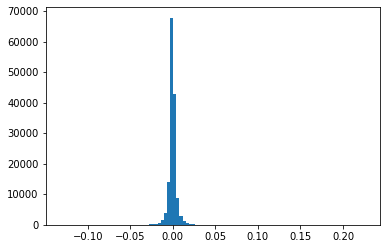

In [731]:
plt.hist(df['iret'], 100)
plt.show()

In [93]:
#dangerous periods, need to check for leveraged positions

#df[df.shortloss.isin(list(df.shortloss.sort_values().head(10)))]
#df[df.longloss.isin(list(df.longloss.sort_values().head(10)))]

In [752]:
consct = 3
print(df[df.sign!='eq'][(df.constct==consct)].groupby(['sign','nextsame']).count()['t'] / df[df.sign!='eq'][(df.constct==consct)].groupby(['sign']).count()['t'])
print('')
df[(df.constct==consct) & (df.sign=='pos')].nextiret.sum(), df[(df.constct==consct) & (df.sign=='neg')].nextiret.sum()

sign  nextsame
neg   False       0.564625
      True        0.435375
pos   False       0.557151
      True        0.442849
Name: t, dtype: float64



(-1.9898932713327044, 1.9616068711604266)

In [622]:
# 5min

sign  nextsame
neg   False       0.551221
      True        0.448779
pos   False       0.540080
      True        0.459920
Name: t, dtype: float64



(-1.8127433946475358, 2.0486154956606724)

In [610]:
## 1h freq

sign  nextsame
neg   False       0.597636
      True        0.402364
pos   False       0.579903
      True        0.420097
Name: t, dtype: float64



(-1.0667479372428226, 0.5518248542441102)

In [234]:
## 30min freq

sign  nextsame
neg   False       0.578830
      True        0.421170
pos   False       0.582405
      True        0.417595
Name: t, dtype: float64



(-1.7976998093933776, 1.6256380275686164)

In [260]:
## 15m freq

sign  nextsame
neg   False       0.581898
      True        0.418102
pos   False       0.560987
      True        0.439013
Name: t, dtype: float64



(-0.8895344748028401, 2.314235823908627)

In [264]:
consct = 3
sl = 0.03
print(df[df.sign!='eq'][(df.constct==consct) & (abs(df.iret)<sl)].groupby(['sign','nextsame']).count()['t'] / df[df.sign!='eq'][(df.constct==consct) & (abs(df.iret)<sl)].groupby(['sign']).count()['t'])
print('')
df[(df.constct==consct) & (df.sign=='pos')].nextiret.sum(), df[(df.constct==consct) & (df.sign=='neg')].nextiret.sum()

sign  nextsame
neg   False       0.581801
      True        0.418199
pos   False       0.560468
      True        0.439532
Name: t, dtype: float64



(-0.8895344748028401, 2.314235823908627)

In [263]:
sl = 0.03
print(df[df.sign!='eq'][(df.constct==consct) & (abs(df.iret)>sl)].groupby(['sign','nextsame']).count()['t'] / df[df.sign!='eq'][(df.constct==consct) & (abs(df.iret)>sl)].groupby(['sign']).count()['t'])

sign  nextsame
neg   False       0.600000
      True        0.400000
pos   False       0.709677
      True        0.290323
Name: t, dtype: float64


In [146]:
#Robotonto 1.0 - strategy returns
print('max loss: long', round(df.loc[(df.constct==3) & (df.sign=='neg')]['longloss'].max(), 4), 'short', round(df.loc[(df.constct==3) & (df.sign=='pos')]['shortloss'].max(), 4))

df.loc[(df.constct==3) & (df.sign=='neg'), 'long3'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret']
df['long3'].fillna(0, inplace=True)
df.loc[(df.constct==3) & (df.sign=='pos'), 'short3'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret']
df['short3'].fillna(0, inplace=True)

df.loc[(df.constct==3) & (df.sign=='neg'), 'longshort3'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret']
df.loc[(df.constct==3) & (df.sign=='pos'), 'longshort3'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret']
df['longshort3'].fillna(0, inplace=True)

df.loc[(df.constct==2) & (df.sign=='neg'), 'long2'] = df.loc[(df.constct==2) & (df.sign=='neg'), 'nextiret']
df['long2'].fillna(0, inplace=True)
df.loc[(df.constct==2) & (df.sign=='pos'), 'short2'] = -df.loc[(df.constct==2) & (df.sign=='pos'), 'nextiret']
df['short2'].fillna(0, inplace=True)

df.loc[(df.constct==2) & (df.sign=='neg'), 'longshort2'] = df.loc[(df.constct==2) & (df.sign=='neg'), 'nextiret']
df.loc[(df.constct==2) & (df.sign=='pos'), 'longshort2'] = -df.loc[(df.constct==2) & (df.sign=='pos'), 'nextiret']
df['longshort2'].fillna(0, inplace=True)

max loss: long -0.1486 short -0.0713


In [148]:
## try 2
print('max loss: long', round(df.loc[(df.constct==3) & (df.sign=='neg')]['longloss'].max(), 4), 'short', round(df.loc[(df.constct==3) & (df.sign=='pos')]['shortloss'].max(), 4))

df.loc[(df.constct==3) & (df.sign=='neg'), 'ls3'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret']
df.loc[(df.constct==3) & (df.sign=='pos'), 'ls3'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret']
df['ls3'].fillna(0, inplace=True)

df.loc[(df.constct==3) & (df.sign=='neg'), 'ls3_2x'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret'] * 2
df.loc[(df.constct==3) & (df.sign=='pos'), 'ls3_2x'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret'] * 2
df['ls3_2x'].fillna(0, inplace=True)

df.loc[(df.constct==3) & (df.sign=='neg'), 'ls3_3x'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret'] * 3
df.loc[(df.constct==3) & (df.sign=='pos'), 'ls3_3x'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret'] * 3
df['ls3_3x'].fillna(0, inplace=True)

max loss: long -0.1486 short -0.0713


In [774]:
## try risk management

#x = df.loc[200000:].copy()

lev = 3
takfee = 0.00075

print('max loss: long', round(df.loc[(df.constct==3) & (df.sign=='neg')]['longloss'].max(), 4), 'short', round(df.loc[(df.constct==3) & (df.sign=='pos')]['shortloss'].max(), 4))

df.loc[(df.constct==3) & (df.sign=='neg'), 'ls3'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret'] * lev - takfee
df.loc[(df.constct==3) & (df.sign=='pos'), 'ls3'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret'] * lev - takfee
df['ls3'].fillna(0, inplace=True)

# stop loss
sl = 0.03
df['ls3_sl'] = df['ls3']
df.loc[(df.constct==3) & (df.sign=='neg') & (df.longloss>sl), 'ls3_sl'] = -sl*lev - takfee
df.loc[(df.constct==3) & (df.sign=='pos') & (df.shortloss>sl), 'ls3_sl'] = -sl*lev - takfee
df['ls3_sl'].fillna(0, inplace=True)

# take profit
tp = 0.03
df['ls3_tp'] = df['ls3']
df.loc[(df.constct==3) & (df.sign=='neg') & (df.shortloss>tp), 'ls3_tp'] = tp*lev - takfee
df.loc[(df.constct==3) & (df.sign=='pos') & (df.longloss>tp), 'ls3_tp'] = tp*lev - takfee
df['ls3_tp'].fillna(0, inplace=True)

max loss: long 0.1605 short 0.1467


In [ ]:
## stay invested 2 per
lev = 3
takfee = 0.00075

print('max loss: long', round(df.loc[(df.constct==3) & (df.sign=='neg')]['longloss'].max(), 4), 'short', round(df.loc[(df.constct==3) & (df.sign=='pos')]['shortloss'].max(), 4))

df.loc[(df.constct==3) & (df.sign=='neg'), 'ls3'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret'] * lev - takfee
df.loc[(df.constct==3) & (df.sign=='pos'), 'ls3'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret'] * lev - takfee
df['ls3'].fillna(0, inplace=True)

In [514]:
#df.loc[(df.constct==3) & (df.sign=='neg') & (df.shortloss>tp)].head(5)

In [515]:
#df.loc[1809:1815,:]

In [274]:
df.loc[(df.constct==3) & (df.sign!='eq')].groupby('nextsame').count()['t'] / df.loc[(df.constct==3) & (df.sign!='eq')].count()['t']

nextsame
False    0.571174
True     0.428826
Name: t, dtype: float64

In [397]:
sl = 0.02 #above 2% less likely to revert
print('all', df.loc[(df.constct==3) & (df.sign!='eq') & ((df.iret>sl) | (df.iret<-sl))].groupby('nextsame').count()['t'] / df.loc[(df.constct==3) & (df.sign!='eq') & ((df.iret>sl) | (df.iret<-sl))].count()['t'])
print('pos', df.loc[(df.constct==3) & (df.sign!='eq') & (df.sign=='pos') & (df.iret>sl)].groupby('nextsame').count()['t'] / df.loc[(df.constct==3) & (df.sign!='eq') & (df.sign=='pos') & (df.iret>sl)].count()['t'])
print('neg', df.loc[(df.constct==3) & (df.sign!='eq') & (df.sign=='neg') & (df.iret<-sl)].groupby('nextsame').count()['t'] / df.loc[(df.constct==3) & (df.sign!='eq') & (df.sign=='neg') & (df.iret<-sl)].count()['t'])

all nextsame
False    0.583333
True     0.416667
Name: t, dtype: float64
pos nextsame
False    0.634146
True     0.365854
Name: t, dtype: float64
neg nextsame
False    0.54918
True     0.45082
Name: t, dtype: float64


In [371]:
print(round(len(dfll[dfll.nextiret<-sl]) / len(dfll),4), 'of times sl by long is good')
print(round(len(dfshl[dfshl.nextiret>sl]) / len(dfshl),4), 'of times sl by short is good')

0.3929 of times sl by long is good
0.3939 of times sl by short is good


In [425]:
## stop loss
lev = 1
sl = 0.02
dfll = df.loc[(df.constct==3) & (df.sign=='neg') & (df.longloss>sl/lev)]
dfshl = df.loc[(df.constct==3) & (df.sign=='pos') & (df.shortloss>sl/lev)]

print(round(len(dfll[dfll.nextiret<-sl]) / len(dfll),4), 'of times sl by long is good')
print(round(len(dfshl[dfshl.nextiret>sl]) / len(dfshl),4), 'of times sl by short is good')
print('sl by long loss:', round((dfll.nextiret + sl).sum(),4), 'sl by short loss:', round(-(dfshl.nextiret - sl).sum(), 4))

0.4672 of times sl by long is good
0.4605 of times sl by short is good
sl by long loss: 0.0795 sl by short loss: -0.0117


In [458]:
## take profit
tp = 0.03
dflp = df.loc[(df.constct==3) & (df.sign=='neg') & (df.shortloss>tp)]
dfshp = df.loc[(df.constct==3) & (df.sign=='pos') & (df.longloss>tp)]

print(round(len(dflp[dflp.nextiret<tp]) / len(dflp),4), 'of times tp by long is good')
print(round(len(dfshp[dfshp.nextiret>-tp]) / len(dfshp),4), 'of times tp by short is good')
print('tp by long profit:', round(-(dflp.nextiret - tp).sum(), 4), 'sl by short profit:', round((dfshp.nextiret+tp).sum(), 4))

0.5385 of times tp by long is good
0.8 of times tp by short is good
tp by long profit: -0.0786 sl by short profit: 0.127


In [775]:
## calculate portfolio timeseries

#df = df.tail(5000).copy().reset_index(drop=True) ## slice it for testing

#calc portfolios
#retcols = ['iret','long3', 'short3', 'longshort3', 'long2', 'short2','longshort2']
#retcols = ['nextiret','ls3', 'ls3_2x', 'ls3_3x']
#retcols = ['nextiret','ls3_2x']
retcols = ['nextiret','ls3','ls3_sl','ls3_tp']
basedate = df.t[0]

t1 = dt.datetime.now()

dfres = pd.DataFrame()
for retcol in retcols:
    dfres = pd.concat([dfres, rets_to_ts(df[['t',retcol]], basedate, baseval=100, datecol='t', dropfirstrow=False)], axis=1)

timeit(t1, msg='done!')

done! runtime: 1 min 16 sec


In [776]:
#dfres5min = dfres.copy()
#dfres15min = dfres.copy()
#dfres15minfix50 = dfres.copy()
#dfres15minfix50takfee = dfres.copy()
dfres1hfix50takfee = dfres.copy()

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 15:30:00,1248.852674,178386.826697,115399.544323,221565.896083
2021-10-19 15:45:00,1248.852674,178386.826697,115399.544323,221565.896083


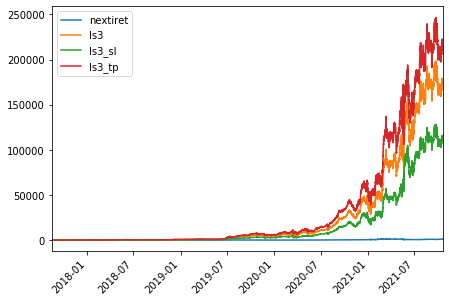

In [767]:
print(str(dfres15min.index[0]), '-', str(dfres15min.index[-1]))
dfres15min.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres15min.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 15:30:00,1248.852674,196112.532596,128280.56643,215543.10065
2021-10-19 15:45:00,1248.852674,196112.532596,128280.56643,215543.10065


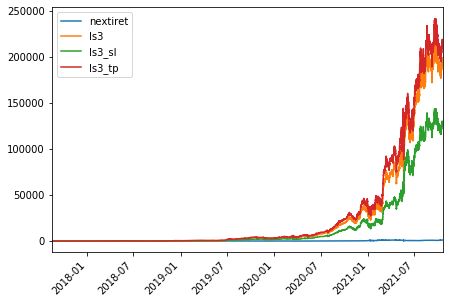

In [766]:
print(str(dfres15minfix50.index[0]), '-', str(dfres15minfix50.index[-1]))
dfres15minfix50.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres15minfix50.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 15:30:00,1248.852674,0.858701,0.561558,0.943895
2021-10-19 15:45:00,1248.852674,0.858701,0.561558,0.943895


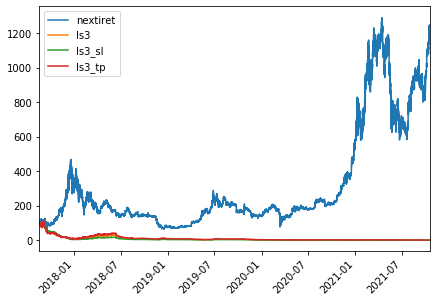

In [765]:
print(str(dfres15minfix50takfee.index[0]), '-', str(dfres15minfix50takfee.index[-1]))
dfres15minfix50takfee.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres15minfix50takfee.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:00:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 14:00:00,1421.001907,160.369151,73.100811,319.599986
2021-10-19 15:00:00,1421.001907,160.369151,73.100811,319.599986


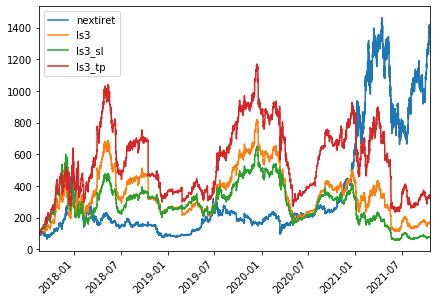

In [777]:
print(str(dfres.index[0]), '-', str(dfres.index[-1]))
dfres.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 15:30:00,1248.852674,196112.532596,128280.56643,215543.10065
2021-10-19 15:45:00,1248.852674,196112.532596,128280.56643,215543.10065


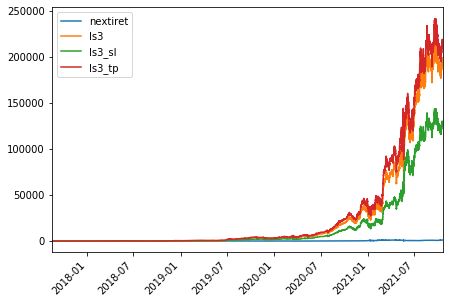

In [758]:
print(str(dfres.index[0]), '-', str(dfres.index[-1]))
dfres.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres.tail(2)

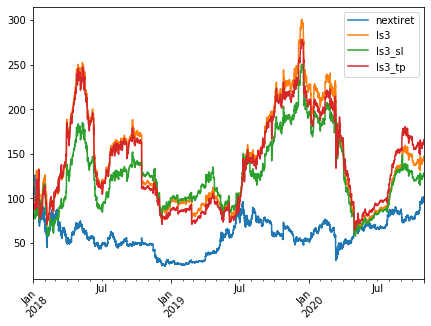

In [781]:
basedate_= '2018-01-01'
todate= '2020-11-01'

#dfres = dfres[1:].copy()
x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,:]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);

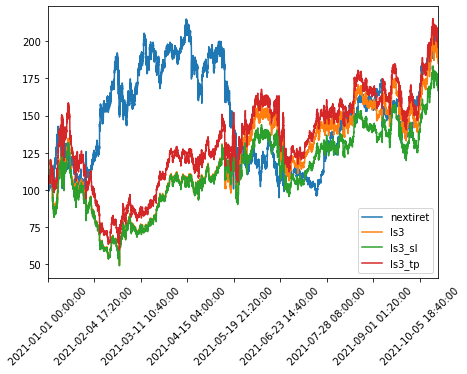

In [700]:
basedate_= '2021-01-01'
todate= '2021-11-01'

#dfres = dfres[1:].copy()
x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,:]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);

In [698]:
x.tail()

,nextiret,ls3,ls3_sl,ls3_tp
2020-04-30 23:35:00,119.016264,52201.716156,50384.407697,65802.050523
2020-04-30 23:40:00,118.480143,52201.716156,50384.407697,65802.050523
2020-04-30 23:45:00,118.334857,52201.716156,50384.407697,65802.050523
2020-04-30 23:50:00,118.197529,52201.716156,50384.407697,65802.050523
2020-04-30 23:55:00,117.741435,51597.416401,49801.145546,65040.309991


In [685]:
#list(dfstat.level_0.drop_duplicates())
dftest = dfres.copy()
#dftest.index = pd.to_datetime(dftest.index, format='%Y-%m-%d', dayfirst=True) # <--------------------------- if needed
dailyfreq = np.array(dftest.index[:-1])[dftest.index[:-1].time > dftest.index[1:].time]
dftest = dftest[dftest.index.isin(dailyfreq)].copy()
dfstat = ht.calc_stats(dftest, freq='d', periods=[1,2,3,4], bm_col='nextiret')
dfstat = dfstat.reset_index()
list1 = ['Ret mean ann.','StDev ann.','MaxDD']
dfstat[dfstat.level_0.isin(list1)]

,level_0,level_1,nextiret,ls3,ls3_sl,ls3_tp
10,Ret mean ann.,from 2017-08-17,0.582354,1.976581,1.944565,2.135834
11,Ret mean ann.,4y,0.558267,1.946475,1.927421,2.084803
12,Ret mean ann.,3y,0.679363,2.316968,2.259345,2.382031
13,Ret mean ann.,2y,0.859940,2.222920,2.173713,2.281366
14,Ret mean ann.,1y,1.421294,1.399119,1.251823,1.423244
15,StDev ann.,from 2017-08-17,0.704993,0.827946,0.828946,0.844740
16,StDev ann.,4y,0.664196,0.805932,0.804154,0.824746
17,StDev ann.,3y,0.608485,0.678631,0.687030,0.674152
18,StDev ann.,2y,0.616987,0.718202,0.728467,0.708766
19,StDev ann.,1y,0.665374,0.804481,0.825188,0.787443


In [ ]:
ht.calc_stats(dftest, freq='d', periods=[], bm_col='NSDQ100')

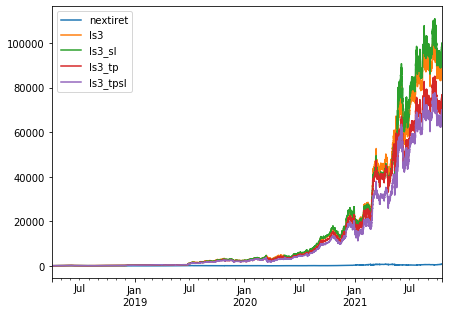

In [522]:
basedate_= '2018-04-01'
todate= '2021-11-01'
x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,:]
rebase(x, basedate_=basedate_, baseval=100).plot(figsize=(7, 5));

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,iret,long3,short3,longshort3,long2,short2,longshort2
2021-10-19 15:30:00,1246.754501,878.253482,221.750642,1947.532732,125.116128,176.162278,220.407421
2021-10-19 15:45:00,1248.852674,878.253482,221.750642,1947.532732,125.116128,176.162278,220.407421


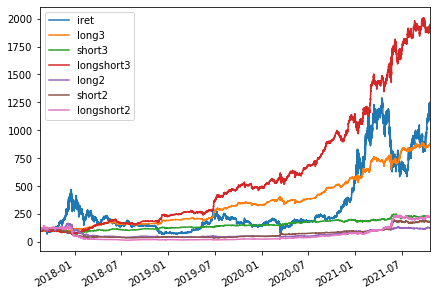

In [85]:
print(str(dfres.index[0]), '-', str(dfres.index[-1]))
dfres.iloc[:,:].plot(figsize=(7, 5))
dfres.tail(2)

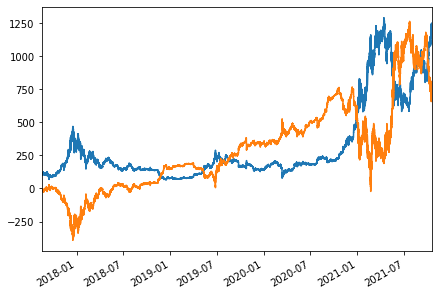

In [89]:
dfres['iret'].plot(figsize=(7, 5))
((dfres['longshort3'] - dfres['nextiret'])).plot(figsize=(7, 5))

In [ ]:
#TO DO
# try staying invested for 2 periods, not just 1
# try alternating long short depending on the short term trend: on uptrend only long